In [35]:
import chickpea
import legume
import numpy as np
import time

%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Background

These tutorials presume basic familiarity with the concepts of photonic band gaps and wave mechanics.
Recommended reading for those unfamiliar is the textbook [Molding the Flow of Light](http://ab-initio.mit.edu/book/),
In particular Chapters 1-5, 7-8.

Chickpea is an add on to the simulation package legume. Legume implements a differentiable
guided mode expansion for studying photonic crystal slabs.
The guided mode expansion is an approximate method that can quickly calculate
mode loss rates and generate mode profiles to a variable degree of precision.

Chickpea implements two packages to aid the analysis of photonic crystal cavities
in particular.

The `PhotonicCrystalCavity` class provides constructors for Lm-n and Hn crystal topologies,
while the `CavityModeAnalysis` class provides tools to analyze and find
localized modes in photonic crystal cavity.

### Cavity Topology

Photonic crystal cavities can be classified by their topology. Examples implemented in Chickpea are H_n and L_m-n crystals.
Both of these topologies are built on hexagonal lattices of holes that maintain a TE bandgap.

In H_n crystals, n hexagonal rings of holes removed from the defect region. In L_m/n crystals,
n holes are replaced by m holes in a line.

The precise placement and parameters of these holes is not a matter of topology but of optimization.

For our analysis we choose an H2 Crystal, not just because of its presence in literature (see Y. Tang 2005),
but also because of the availability of analysis done using alternative
[FDTD techniques](https://support.lumerical.com/hc/en-us/articles/360041567754-Photonic-crystal-cavity).

We can use these results to evalulate the effectiveness of legume.

### Analysis

We begin by defining our crystal, as we do so we have several choices to make.
The supercell we define, including the defect region, will be tiled infinitely,
how many periods of bulk crystal should lie between each defect region?
See Tutorial on [Localization and Supercell Effects](04_Localization_and_Supercell_Effects.ipynb)
for an answer. We choose the anzats of 18 in both directions.


In [36]:
#Number of PhC periods in x and y directions.

Nx, Ny = 18, 18

a=1 # Bulk Lattice constant.

# Regular PhC parameters chosen from Tang et al.
dslab = 0.26/0.366*a
n_slab = 3.4
ra = 0.37*a

# We use the PCC module of chickpea to initialize an H2 Crystal lattice topology.

pcc = chickpea.PhotonicCrystalCavity(crystal='H', n=2, supercell_size=(Nx, Ny),
                                     thickness=dslab, radius=ra, eps=n_slab**2)

# We generate the photonic crystal object from the photonic crystal cavity object.
phc = pcc.cavity()

We can visualize the cavity using the legume visualization tool.

array([[11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       ...,
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56]])

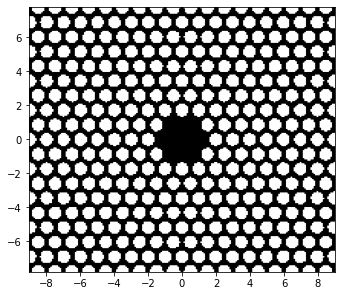

In [37]:
legume.viz.eps_xy(phc, z=dslab/2, Nx=200, Ny=200)

To analyze defect modes in the H2 Crystal it is useful to know some properties of the base crystal
the defect is embedded in.

We can use the pcc object to provide our base crystal for us.

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

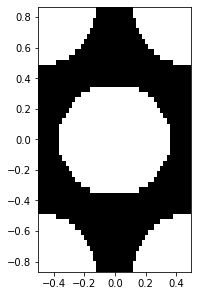

In [38]:
base_phc = pcc.get_base_crystal()
legume.viz.eps_xy(base_phc, z=dslab/2, Nx=50, Ny=50)

We can aid and automate our analysis using the `CavityModeAnalysis` object provided by Chickpea.
To do so we first need to define some meta-parameters.

Legume simulates over a fourier series of the defined permittivity distribution.
Note this is a *fourier series*. The permitivity distribution as defined is continuous and the
fourier series naturally has infinitely many terms.

The fourier series is truncated. The point of truncation is determined by the parameter `gmax`.

We choose a `gmax` of 2 for both the base crystal and the cavity. We do not expect to get particularly accurate
values for Q at this gmax, however we can analyze frequency.
See the tutorial [Convergence and gmax](03_Convergence_and_gmax.ipynb).

Another parameter is the defect margins parameter. This defines the margins of the crystal we can ignore for the purpose of mode volume calculations.
For explanation see [Normalization and Mode Volume](05_Normalization_and_Mode_Volume.ipynb) tutorial.

In [39]:
defect_margins = np.array([0.25,0.25])
cma = chickpea.CavityModeAnalysis(phc, base_phc, defect_margins, layer=0, gmax=2, base_gmax=3)

The Cavity Mode Analysis object helps us keep track of all the information about the photonic crystal cavity.
Including the behaviour of the bulk crystal.
We know that the modes are going to be located in the band gap of the bulk crystal we can find the band gaps
and generate a band diagram via the `find_band_gaps` function.

Band gap lower bound: 0.276746.
Band gap upper bound: 0.420195.
Band gap center: 0.348471.
Gap-midgap ratio: 0.411654.
The top of the air band is at k= (3.141593, 1.813799).
The bottom of the dielectric band is at k= (4.188790, 0.000000).



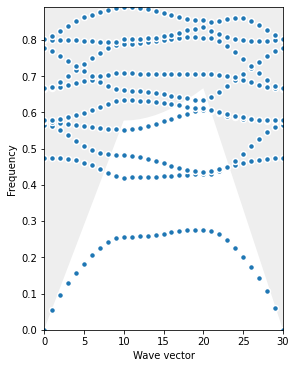

In [40]:
band_gaps, k_air, k_eps =cma.find_band_gaps(band_tol=0.1,
                                            order=np.array([0]), # The order of modes that we care about.
                                                                 # TE modes are numbers [0,2,4,6,8]
                                                                 # We happen to know that higher order modes are
                                                                 # well above the bandgap
                                            trim_lc=True, # We only care about out of light-cone modes.
                                            lc_trim=0.04, # The lc-trim parameter governs how close to the light cone
                                                          # we tolerate.
                                            numeig=10)

gmg_ratio = np.array([(band_gap[1] - band_gap[0]) / band_gap[2] for band_gap in band_gaps])

legume.viz.bands(cma.base_gme,  trim_light_cone=False, lc_trim=0.04)

# There is only one band-gap for this crystal with properties.
print("Band gap lower bound: %f.\n"
      "Band gap upper bound: %f.\n"
      "Band gap center: %f.\n"
      "Gap-midgap ratio: %f.\n"
      "The top of the air band is at k= (%f, %f).\n"
      "The bottom of the dielectric band is at k= (%f, %f).\n" %  (band_gaps[0][0], band_gaps[0][1], band_gaps[0][2],
                                                                   gmg_ratio[0], k_air[0], k_air[1], k_eps[0], k_eps[1]))

We see a band gap between $\frac{a\omega}{2\pi c}=0.276$ and $\frac{a\omega}{2\pi c}=0.42$.
We would expect to find defect modes in this region. We set our target frequency to the center of
this band gap and simulate.

In [ ]:

options = {'verbose': True,
           'gmode_inds': [0], # This is a TE band gap and we assume that there are no higher order modes.
           'gradients': 'approx', # We don't need exact gradients at this time.
           'numeig': 50, # We happen to know this is a good number to fill the band gap.
                         # Run with higher value until you save modes outside of the band gap.
           'eig_solver': 'eigh',
           'gmode_step': 1e-3, # there are some near-degenerate modes in this system we must lower the step size.
           'eig_sigma': band_gaps[0][2], # We target the center of the band gap
           'compute_im': False # We only want to calculate the loss rates for cavity modes.
           }

# We simulate on a k-point near the center of the light cone.

kpoints = np.array([[k_air[0][0]],[k_air[1][0]]])

%memit cma.gme.run(kpoints=kpoints, **options)

Running k-point 1 of 1

We can then use the `filter_for_defect_mode` function to search for high mode volume (localized) modes within the band gap.

In [ ]:
arg_list, v = cma.filter_for_defect_mode(max_volume=5, band_filter=None)
print('List of mode indices of target modes: '+str(list(arg_list)))

The arg list returned is a list of lists, with the index of each list corresponding to the k index of the
GuidedModeExpansion object. Within the lists are the indices of the filtered modes.

Let us now calculate the Q factor for these modes and plot the electromagnetic field with this
information for all filtered modes.

Plotting the electromagnetic field can take time as an inverse fourier transform must be taken for
each sampled point.

The mode profiles of all of these modes is plotted below.

In [ ]:

q, _, _, _ = cma.calculate_loss_rates_and_coupling(arg_list)

In [ ]:
for kind, mlist in enumerate(arg_list):
    for i, mind in enumerate(mlist):
        fig=legume.viz.field(cma.gme,'E', kind, mind, z=dslab/2, component='xy', val='abs', N1=200, N2=200, norm=True)
        fig.text(0.5,-0.25,
                 "arg: " + str(mind)+ "\n"
                 + "freq: " + str(cma.gme.freqs[kind][mind]) + "\n"
                 + "Rough Mode Volume: " + str(v[kind][i]) + "\n"
                 + "Rough Q: " + str(q[kind][i]))

We see a list of mode profiles and frequencies that the reader can compare with results from
[FDTD methods](https://support.lumerical.com/hc/en-us/articles/360041567754-Photonic-crystal-cavity).

Given a brief survey of the mode profiles we determine that legume can reproduce the results of the
FDTD technique, finding modes over a larger range of frequencies, with a fourier component calculation
taking only 140 seconds, and accurate results for frequency.

